TweetEmotion using DistillBert

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  basepath = '/content/drive/MyDrive/NLP_HW_6_Dipasha'
else:
  basepath = '/content/drive/MyDrive/NLP_HW_6_Dipasha'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
#Importing neccessary modules
import torch
import torch.nn as nn
import pandas as pd
from torchtext.vocab import vocab
import random
import numpy as np
import joblib
from collections import Counter
from functools import partial
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import os
import wandb

In [ ]:
#Defining base and model folders
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'

In [ ]:
data_folder = '/content/drive/MyDrive/NLP_HW_6_Dipasha/datasets'
train_file = 'train.csv'
test_file = 'test.csv'

In [ ]:
from bs4 import BeautifulSoup
import re

In [ ]:
#basic cleaning data
def basic_clean(text: str) -> str:
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    return re.sub(r'[\n\r]',' ', text)

In [ ]:
from sklearn.model_selection import train_test_split

#Reading dataframes from given CSV
train_df = pd.read_csv(os.path.join(data_folder, train_file))
test_df = pd.read_csv(os.path.join(data_folder, test_file))

train_df.fillna(value={'Tweet': 'placeholder'}, inplace=True)
test_df.fillna(value={'Tweet': 'placeholder'}, inplace=True)

print("Number of rows in data =",train_df.shape[0])
print("Number of columns in data =",train_df.shape[1])

Number of rows in data = 7724
Number of columns in data = 13


In [ ]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


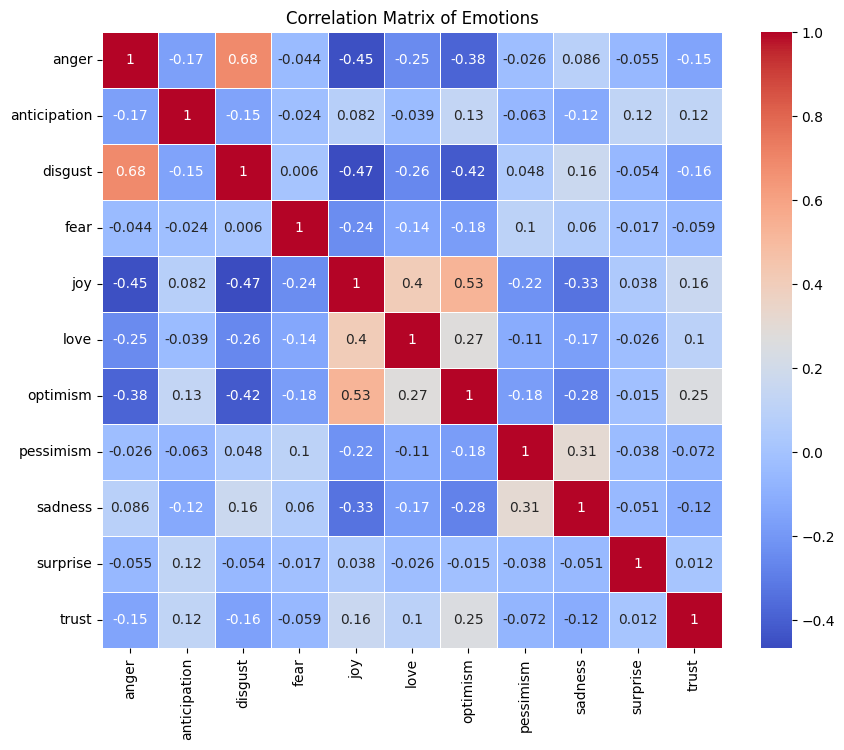

In [ ]:
#Correlation Matrix of all emotions
emotions_corr = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(emotions_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Emotions')
plt.show()


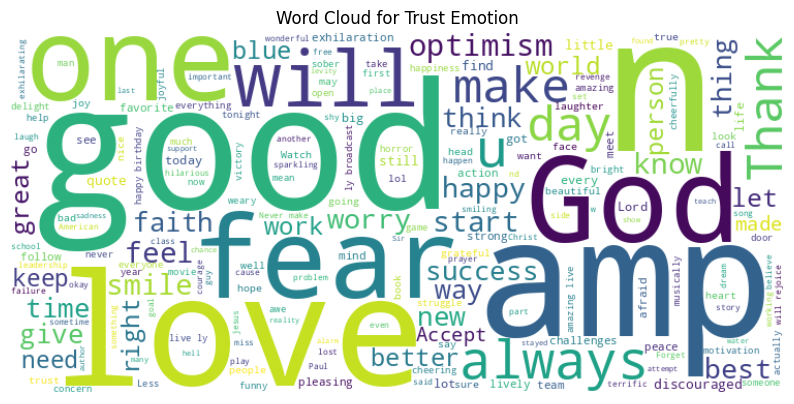

In [ ]:
#Plotting a word cloud for exploration
from wordcloud import WordCloud

text = ' '.join(train_df[train_df['trust'] == 1]['Tweet'])
wordcloud = WordCloud(width=750, height=350, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Trust Emotion')
plt.show()


In [ ]:
train_df,val_df= train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_df.shape

(6179, 13)

In [ ]:
val_df.shape

(1545, 13)

In [ ]:
test_df.shape

(3259, 13)

In [ ]:
train_df['Tweet'] = train_df['Tweet'].apply(basic_clean)
val_df['Tweet'] = val_df['Tweet'].apply(basic_clean)
test_df['Tweet'] = test_df['Tweet'].apply(basic_clean)

<ipython-input-6-4c18cd4a5bb7>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-6-4c18cd4a5bb7>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-6-4c18cd4a5bb7>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
X_train = train_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_train = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [ ]:
X_train.shape

(6179, 2)

In [ ]:
y_train.shape

(6179, 11)

In [ ]:
X_val = val_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_val = val_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [ ]:
test_df.replace('NONE', 0, inplace=True)
X_test = test_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_test = test_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [ ]:
trainset = Dataset.from_dict({
    'texts': X_train['Tweet'],
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_val['Tweet'],
    'labels': y_val
})

testset = Dataset.from_dict({
    'texts': X_test['Tweet'],
    'labels': y_test
})

In [ ]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
trainset

Dataset({
    features: ['texts', 'labels'],
    num_rows: 6179
})

In [ ]:
trainset[:1]

{'texts': ["Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting"],
 'labels': [[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]]}

In [ ]:
custom_label_names =['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [ ]:
test_val_splits = trainset.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


In [ ]:
train_split_small = train_split.shuffle(seed=42).select(range(2000))
val_split_small = val_split.shuffle(seed=42).select(range(500))
test_split_small = test_split.shuffle(seed=42).select(range(500))

In [ ]:
from datasets import DatasetDict
# combine train, val splits into one dataset
train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_dataset = DatasetDict({'test': test_split})

# create subsets of train and val datasets
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create subset for test dataset
test_subset = DatasetDict({'test': test_split_small})



In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['texts', 'labels'],
        num_rows: 500
    })
})

In [ ]:
train_val_subset['train'].features


{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    return tokenizer(batch["texts"], truncation=True)

In [ ]:
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['texts', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset.set_format(type='torch')
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_label", "labels"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}

In [ ]:
tokenized_dataset['train']['labels'][0:3]

tensor([[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.]])

In [ ]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

24
36


In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels=11
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels,
                                                           problem_type="multi_label_classification")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transf

In [ ]:
custom_label_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
id2label = {}
for id_, label_ in enumerate(custom_label_names):
    id2label[str(id_)] = label_
id2label


{'0': 'anger',
 '1': 'anticipation',
 '2': 'disgust',
 '3': 'fear',
 '4': 'joy',
 '5': 'love',
 '6': 'optimism',
 '7': 'pessimism',
 '8': 'sadness',
 '9': 'surprise',
 '10': 'trust'}

In [ ]:
label2id = {}
for id_, label_ in enumerate(custom_label_names):
    label2id[label_] = id_
label2id


{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'love': 5,
 'optimism': 6,
 'pessimism': 7,
 'sadness': 8,
 'surprise': 9,
 'trust': 10}

In [ ]:
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
model.config


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "10": "trust",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_versi

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
features = [tokenized_dataset["train"][i] for i in range(2)]

In [ ]:
features

[{'input_ids': tensor([  101,  1045,  2428,  2215,  2000,  2175,  2005, 25966,  2305,  2021,
           1045,  2428,  2123,  1005,  1056,   100,   102]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])},
 {'input_ids': tensor([  101,  4121, 26478,  8609,  2015,  2000,  2026,  2814,  2012,  1030,
          11675,  5302, 13469,  2006,  1996,  1001,  3915, 28139,  9856,  2890,
           4826,   999,  1001,  2143,  1001,  1996,  6767,  3593,  1001,  3444,
          23665,  1001, 12459,  6182,  2102,   102]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])}]

In [ ]:
model_input = data_collator(features)
model_input.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
print(model_input.input_ids[0][0:10])
print(model_input.input_ids[0][-20:])
print(model_input.input_ids[1][0:10])
print(model_input.input_ids[1][-20:])

tensor([  101,  1045,  2428,  2215,  2000,  2175,  2005, 25966,  2305,  2021])
tensor([102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
tensor([  101,  4121, 26478,  8609,  2015,  2000,  2026,  2814,  2012,  1030])
tensor([ 3915, 28139,  9856,  2890,  4826,   999,  1001,  2143,  1001,  1996,
         6767,  3593,  1001,  3444, 23665,  1001, 12459,  6182,  2102,   102])


In [ ]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][0:10]))

['[CLS]', 'i', 'really', 'want', 'to', 'go', 'for', 'fright', 'night', 'but']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][-10:]))

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][0:10]))

['[CLS]', 'huge', 'cong', '##rat', '##s', 'to', 'my', 'friends', 'at', '@']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][-10:]))

['##vo', '##id', '#', 'feature', '##film', '#', 'scary', '##shi', '##t', '[SEP]']


In [ ]:

model=model
model_input= model_input
model.train()
model_output = model(**model_input)

In [ ]:
model_output.keys()

odict_keys(['loss', 'logits'])

In [ ]:
model_output.loss

tensor(0.7210, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
model_output.logits

tensor([[ 0.2323,  0.0340,  0.0939, -0.1998, -0.0112, -0.1117,  0.0065,  0.2429,
          0.0137, -0.1557,  0.1267],
        [ 0.1870,  0.0136,  0.1200, -0.0365, -0.0181, -0.0223, -0.0975,  0.1988,
          0.0566, -0.1593,  0.0399]], grad_fn=<AddmmBackward0>)

In [ ]:
model_output.logits.shape

torch.Size([2, 11])

In [ ]:
def compute_metrics(eval_pred):
    # Split the evaluation predictions into logits (model predictions) and actual labels.
    logits, labels = eval_pred
    labels = labels.astype(int)  # Convert labels to integer type

    # Convert logits to binary predictions.
    predictions = (logits > 0).astype(int)

    # Flatten the predictions and labels for metric computation.
    flat_predictions = predictions.flatten()
    flat_labels = labels.flatten()

    # Load the metrics
    f1_macro_metric = evaluate.load("f1", average="macro")
    f1_micro_metric = evaluate.load("f1", average="micro")


    # Compute macro F1 score
    macro_f1 = f1_macro_metric.compute(predictions=flat_predictions, references=flat_labels, average="macro")

    # Compute micro F1 score
    micro_f1 = f1_micro_metric.compute(predictions=flat_predictions, references=flat_labels, average="micro")

    # Compute label-wise accuracies
    correct_predictions = (predictions == labels).sum(axis=0)
    total_predictions = predictions.shape[0]
    label_accuracies = correct_predictions / total_predictions

    # Compute the average label accuracy
    avg_label_accuracy = np.mean(label_accuracies)

    # Compute accuracy where all labels for an observation need to be correct
    correct_observations = np.all(predictions == labels, axis=1).sum()
    all_accuracy = correct_observations / total_predictions

    # Combine results
    evaluations = {
        'macro_f1': macro_f1['f1'],
        'micro_f1': micro_f1['f1'],
        'accuracy_all': all_accuracy,
        'avg_label_accuracy': avg_label_accuracy
    }

    return evaluations

In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_hw6_ds/multilabel/dbert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=8,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="macro_f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'mlabel_exp1',  # Experiment name for Weights & Biases
)


In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy All,Avg Label Accuracy
20,0.613800,0.542860,0.440886,0.788545,0.038000,0.788545
40,0.523400,0.494167,0.440886,0.788545,0.038000,0.788545
60,0.479700,0.479966,0.440886,0.788545,0.038000,0.788545
80,0.491700,0.471327,0.440886,0.788545,0.038000,0.788545
100,0.472600,0.464633,0.440886,0.788545,0.038000,0.788545
120,0.477900,0.454334,0.440886,0.788545,0.038000,0.788545
140,0.450300,0.436528,0.643380,0.825091,0.118000,0.825091
160,0.435900,0.422901,0.679762,0.834000,0.140000,0.834000
180,0.409300,0.414439,0.691123,0.825818,0.166000,0.825818
200,0.431100,0.413369,0.664750,0.828000,0.126000,0.828000


TrainOutput(global_step=500, training_loss=0.4152330141067505, metrics={'train_runtime': 2656.4744, 'train_samples_per_second': 1.506, 'train_steps_per_second': 0.188, 'total_flos': 42485387008176.0, 'train_loss': 0.4152330141067505, 'epoch': 2.0})

In [ ]:
trainer.evaluate(tokenized_dataset["val"])


{'eval_loss': 0.364380806684494,
 'eval_macro_f1': 0.7475184855051953,
 'eval_micro_f1': 0.8518181818181818,
 'eval_accuracy_all': 0.19,
 'eval_avg_label_accuracy': 0.8518181818181819,
 'eval_runtime': 66.8748,
 'eval_samples_per_second': 7.477,
 'eval_steps_per_second': 0.942,
 'epoch': 2.0}

In [ ]:
valid_output = trainer.predict(tokenized_dataset["val"])


In [ ]:
valid_output._fields

('predictions', 'label_ids', 'metrics')

In [ ]:
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)

(500, 11)
(500, 11)


In [ ]:
valid_output.predictions[0:2]

array([[-1.2172223 , -1.6784393 , -1.0520557 , -1.1396879 , -0.83818036,
        -2.523191  , -1.0190064 , -1.5272964 , -0.16382213, -2.8655605 ,
        -2.8792167 ],
       [-1.3020403 , -1.6750255 , -1.1948589 , -1.4326141 , -0.7527125 ,
        -2.6773257 , -1.0017867 , -1.9352491 , -0.89637434, -3.0469575 ,
        -2.9074008 ]], dtype=float32)

In [ ]:
predictions = (valid_output.predictions > 0).astype(int)
labels = valid_output.label_ids.astype(int)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(labels, predictions)
print(mcm)


[[[277  54]
  [ 38 131]]

 [[425   0]
  [ 75   0]]

 [[264  60]
  [ 39 137]]

 [[408   0]
  [ 91   1]]

 [[265  49]
  [ 37 149]]

 [[447   0]
  [ 53   0]]

 [[295  48]
  [ 53 104]]

 [[441   0]
  [ 59   0]]

 [[335  16]
  [ 96  53]]

 [[479   0]
  [ 21   0]]

 [[474   0]
  [ 26   0]]]


In [ ]:
custom_label_names =['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [ ]:
wandb.finish()


eval/accuracy_all,▁▁▁▁▁▁▅▅▇▅▇▇▇▇▇▇▇▇▇███████
eval/avg_label_accuracy,▁▁▁▁▁▁▅▆▅▅▆▅▇▇▇▇▇▇▇███████
eval/loss,█▆▆▅▅▅▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/macro_f1,▁▁▁▁▁▁▆▆▇▆▇▇▇▇▇▇██████████
eval/micro_f1,▁▁▁▁▁▁▅▆▅▅▆▅▇▇▇▇▇▇▇███████
eval/runtime,▂▁▁▂▁▁▁▁▂▃▁▂▂▂▂▃▂▁▁▂▃▂▂▁▃█
eval/samples_per_second,▇▇█▆▇███▇▅▇▇▇▇▇▅▇▇▇▇▅▇▇▇▅▁
eval/steps_per_second,▇▇█▆▇███▇▅▇▇▇▇▇▅▇▇▇▇▅▇▇▇▅▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▁▂▁▁▁▂▂▂▂█▃█▁▂▄▁▃▄▃▂▄▇▂▂▂


In [ ]:

best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 500.


In [ ]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['texts', 'labels'],
        num_rows: 500
    })
})

In [ ]:

from torch.utils.data import DataLoader
def evaluator(model, dataset, tokenizer, compute_metrics, batch_size=16):
    """
    Evaluates a model's performance on a given dataset.

    Parameters:
    - model: The trained model to evaluate.
    - dataset: The dataset on which the model will be evaluated.
    - tokenizer: The tokenizer used to preprocess the text data.
    - compute_metrics: A function to compute evaluation metrics.
    - batch_size: Size of batches for evaluation. Default is 16.

    Returns:
    - evaluations: A dictionary containing computed evaluation metrics.
    """

    # Tokenize the dataset and truncate if the tokenized sequence is longer than the model's maximum input length.
    tokenized_dataset= dataset.map(lambda batch: tokenizer(batch["texts"], truncation=True), batched=True)

    # Set the format of the tokenized dataset to be compatible with PyTorch.
    tokenized_dataset.set_format(type='torch')

    # Remove the 'text' column from the tokenized dataset as it's no longer needed post-tokenization.
    tokenized_dataset= tokenized_dataset.remove_columns(['texts'])

    # Define a collation function that pads tokenized sequences to the same length for batching.
    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize a DataLoader to iterate over the tokenized dataset in batches.
    datalaoder = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=collate_fn)

    model.eval()

    # Initialize variables to store the model's logits (raw prediction scores) and true labels.
    eval_logits = None
    eval_labels = None

    # Disable gradient calculations for efficient memory usage during evaluation.
    with torch.inference_mode():
        # Iterate over batches from the DataLoader.
        for batch in datalaoder:
            # Prepare the inputs and move them to the GPU.
            inputs = {k: v for k, v in batch.items() if k != 'labels'}

            # Get the model's predictions for the current batch.
            outputs = model(**inputs)
            logits = outputs.logits
            labels = batch['labels']

            # Append the logits and labels of the current batch to the accumulating variables.
            if eval_logits is None:
                eval_logits = logits.cpu().numpy()
                eval_labels = labels.cpu().numpy()
            else:
                eval_logits = np.append(eval_logits, logits.cpu().numpy(), axis=0)
                eval_labels = np.append(eval_labels, labels.cpu().numpy(), axis=0)

    # Compute evaluation metrics using the provided compute_metrics function.
    evaluations = compute_metrics((eval_logits, eval_labels))

    return evaluations


In [ ]:
evaluations = evaluator(model, test_subset['test'], tokenizer, compute_metrics, batch_size=16)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
evaluations

{'macro_f1': 0.7490304300816621,
 'micro_f1': 0.854,
 'accuracy_all': 0.23,
 'avg_label_accuracy': 0.854}

In [ ]:
from transformers import pipeline
checkpoint = str(model_folder/'checkpoint-500')

custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device="cpu",
    return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
sample = test_subset['test']['texts'][0]
sample

'@littlepieces Customer services got involved and eventually completely wash their hands of it. #awful #dreamornightmare'

In [ ]:
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.7473000884056091},
  {'label': 'anticipation', 'score': 0.10589597374200821},
  {'label': 'disgust', 'score': 0.7973160147666931},
  {'label': 'fear', 'score': 0.244657501578331},
  {'label': 'joy', 'score': 0.09876557439565659},
  {'label': 'love', 'score': 0.05628889426589012},
  {'label': 'optimism', 'score': 0.08923498541116714},
  {'label': 'pessimism', 'score': 0.1916242390871048},
  {'label': 'sadness', 'score': 0.4869406223297119},
  {'label': 'surprise', 'score': 0.09407003223896027},
  {'label': 'trust', 'score': 0.06390359252691269}]]

In [ ]:
sample = test_split['texts'][19]
sample

'Accept the challenges, So that you may feel the exhilaration of victory.\\n\\nTOMIHO IpaglabanMo TapingDay2'

In [ ]:
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.1022973358631134},
  {'label': 'anticipation', 'score': 0.2784181535243988},
  {'label': 'disgust', 'score': 0.09775688499212265},
  {'label': 'fear', 'score': 0.12194078415632248},
  {'label': 'joy', 'score': 0.831660270690918},
  {'label': 'love', 'score': 0.30782419443130493},
  {'label': 'optimism', 'score': 0.699225127696991},
  {'label': 'pessimism', 'score': 0.10453835129737854},
  {'label': 'sadness', 'score': 0.12249904125928879},
  {'label': 'surprise', 'score': 0.09519817680120468},
  {'label': 'trust', 'score': 0.1422920525074005}]]

In [ ]:
predictions = custom_pipeline(test_subset['test']['texts'], truncation=True)

In [ ]:
predictions[:5]

[[{'label': 'anger', 'score': 0.7473000884056091},
  {'label': 'anticipation', 'score': 0.10589597374200821},
  {'label': 'disgust', 'score': 0.7973160147666931},
  {'label': 'fear', 'score': 0.244657501578331},
  {'label': 'joy', 'score': 0.09876557439565659},
  {'label': 'love', 'score': 0.05628889426589012},
  {'label': 'optimism', 'score': 0.08923498541116714},
  {'label': 'pessimism', 'score': 0.1916242390871048},
  {'label': 'sadness', 'score': 0.4869406223297119},
  {'label': 'surprise', 'score': 0.09407003223896027},
  {'label': 'trust', 'score': 0.06390359252691269}],
 [{'label': 'anger', 'score': 0.1348949819803238},
  {'label': 'anticipation', 'score': 0.22917254269123077},
  {'label': 'disgust', 'score': 0.11822078377008438},
  {'label': 'fear', 'score': 0.11436876654624939},
  {'label': 'joy', 'score': 0.7242513298988342},
  {'label': 'love', 'score': 0.17017218470573425},
  {'label': 'optimism', 'score': 0.5787230730056763},
  {'label': 'pessimism', 'score': 0.09442525357

In [ ]:
import numpy as np
from transformers import Pipeline

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

class MultiLabelClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        return preprocess_kwargs, {}, {}

    def preprocess(self, text):
        tokenized = self.tokenizer(text, return_tensors=self.framework, truncation=True, padding=True, max_length=512)
        return tokenized


    def _forward(self, model_inputs):
        model_inputs = {k: v for k, v in model_inputs.items()}
        return self.model(**model_inputs)


    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].cpu().numpy()
        probabilities = sigmoid(logits)

        threshold = 0.46
        labels = [self.model.config.id2label[i] for i, prob in enumerate(probabilities) if prob > threshold]

        scores = [prob for prob in probabilities if prob > threshold]
        return {"labels": labels, "scores": scores}


In [ ]:
checkpoint = str(model_folder/'checkpoint-500')
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

multi_label_pipeline = MultiLabelClassificationPipeline(model=model, tokenizer=tokenizer)


model.device

device(type='cpu')

In [ ]:
sample = test_subset['test']['texts'][0]
sample

'@littlepieces Customer services got involved and eventually completely wash their hands of it. #awful #dreamornightmare'

In [ ]:
preds = multi_label_pipeline(sample)
preds

{'labels': ['anger', 'disgust', 'sadness'],
 'scores': [0.7473001, 0.797316, 0.48694062]}

In [ ]:
sample = test_split['texts'][19]
sample

In [ ]:
preds = multi_label_pipeline(sample)
preds

{'labels': ['joy', 'optimism'], 'scores': [0.8316603, 0.6992251]}

In [ ]:
predictions = multi_label_pipeline(test_subset['test']['texts'], truncation=True)

In [ ]:
predictions

[{'labels': ['anger', 'disgust', 'sadness'],
  'scores': [0.7473001, 0.797316, 0.48694062]},
 {'labels': ['joy', 'optimism'], 'scores': [0.72425133, 0.5787231]},
 {'labels': ['anger', 'disgust'], 'scores': [0.5936927, 0.598385]},
 {'labels': [], 'scores': []},
 {'labels': ['joy', 'optimism'], 'scores': [0.835676, 0.65271044]},
 {'labels': ['anger', 'disgust'], 'scores': [0.7956985, 0.7852308]},
 {'labels': ['joy'], 'scores': [0.59309345]},
 {'labels': ['anger', 'disgust'], 'scores': [0.66716355, 0.680824]},
 {'labels': [], 'scores': []},
 {'labels': [], 'scores': []},
 {'labels': ['joy', 'optimism'], 'scores': [0.7333871, 0.48342443]},
 {'labels': ['joy', 'optimism'], 'scores': [0.81095564, 0.6654426]},
 {'labels': ['disgust', 'sadness'], 'scores': [0.48836684, 0.6369624]},
 {'labels': ['anger', 'disgust'], 'scores': [0.67135084, 0.72601223]},
 {'labels': ['joy'], 'scores': [0.62069833]},
 {'labels': ['joy', 'optimism'], 'scores': [0.8597225, 0.7089759]},
 {'labels': ['joy', 'optimism'

In [ ]:
predictions_test= multi_label_pipeline(testset['texts'], truncation=True)

In [ ]:
# Create DataFrame from predicted labels
submission_df = pd.DataFrame(predictions_test, columns=['labels', 'scores'])

# Initialize columns for all possible labels
for label in custom_label_names:
    submission_df[label] = 0

# Mark predicted labels as 1
for idx, row in submission_df.iterrows():
    for label, score in zip(row['labels'], row['scores']):
        if score >= 0.5:  # Threshold for considering a label as predicted
            submission_df.at[idx, label] = 1

# Merge with test_df to include IDs
submission_df["ID"] = test_df["ID"]
submission_df = submission_df[["ID"] + custom_label_names]

print(submission_df)

              ID  anger  anticipation  disgust  fear  joy  love  optimism  \
0     2018-01559      1             0        1     0    0     0         0   
1     2018-03739      1             0        1     0    0     0         0   
2     2018-00385      1             0        1     0    0     0         0   
3     2018-03001      0             0        0     0    1     0         1   
4     2018-01988      0             0        1     0    0     0         0   
...          ...    ...           ...      ...   ...  ...   ...       ...   
3254  2018-03848      1             0        1     0    0     0         0   
3255  2018-00416      0             0        0     0    1     0         1   
3256  2018-03717      1             0        1     0    0     0         0   
3257  2018-03504      0             0        0     0    1     0         1   
3258  2018-00115      1             0        1     0    0     0         0   

      pessimism  sadness  surprise  trust  
0             0        0       

In [ ]:
from google.colab import files
submission_df.to_csv("submissionDistillbert.csv", index=False)

files.download("submissionDistillbert.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>